Deep Pose Estimation
====================

The goal of this practical is to learn how to use Deep Learning to predict poses from images. For simplicity, we will focus on synthetic images and 2d poses of simple shapes, however the principles remain the same. In fact, for a new research problem, it is always a good idea to start with a toy problem: On the long term, it saves time.

We will use TensorFlow. You can access a tutorial on TensorFlow [there](https://www.labri.fr/perso/vlepetit/teaching/visum/tensorflow.pdf) to get you started. The official [TensorFlow website](tensorflow.org/) (and Internet in general :-) ) provides more detailed information.

We will start with a simple problem with rectangles oriented hozontally and vertically. For this problem, linear regression is enough to get good performance. For the second problem, we will consider rotating triangles, for which we will need a deep network.

Imports
-------

The main libraries we will use are TensorFlow, NumPy, and Matplotlib for drawing images. Our code will therefore start with:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

The line
```
%matplotlib inline
```
is useful only in Jupyter notebooks to visualize the images online.

Creating the data
----------------

The function below generates an image of a rectangle:

In [4]:
def generate_rectangle(figsize, top, left, bottom, right, noise = 0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill((top, top, bottom, bottom), (left, right, right, left), "k")
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')[::3].astype(np.float32)
    plt.close(fig)
    return data

Make sure you understand this function. You will see that it returns the image as a vector of 72x72=5184 values. We can test it with:

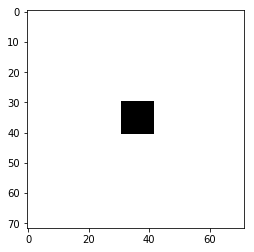

In [5]:
im = generate_rectangle(1, 0.6, 0.4, 0.4, 0.6, 40)
plt.imshow(im.reshape(72,72), cmap='gray')

The <code>noise</code> parameter to the <code>generate_rectangle</code> function is actually not used. <b>Modify the function to add uniform noise to the image to make it more realistic.</b>

<b>Call the function below to generate a training set</b> <code> X_train, Y_train</code> <b>and a test set</b> <code> X_test, Y_test</code>:

In [6]:
def generate_data(nb_samples, noise):
    X = np.ones([nb_samples,im_size])
    Y = np.ones([nb_samples,4])
    # We fill the array
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
        X[i] = generate_rectangle(1, top, left, bottom, right, noise)
        Y[i,0] = top
        Y[i,1] = left
        Y[i,2] = bottom
        Y[i,3] = right 
    return [X, Y]

The optimization algorithms we will implement below converge better if the input values have coefficients between 0 and 1. <b>Modify</b> <code>X_train</code> and <code>X_test</code> accordingly.

Here comes the first real Machine Learning part :-)
------------------------------------------------

We want to predict from an image containing a rectangle the 4 values defining this rectangle. Since this is still a relatively simple problem, we will use linear regression of the form:
$$
y_\text{pred} = x^\top W + b
$$
where $x$ is the image, $W$ a matrix, $b$ a vector, and $y_\text{pred}$ a 4-vector containing the 4 values to predict. Our goal is to learn $W$ and $b$.

<b>Write the code</b> defining $x$, $W$, $b$, and $y_\text{pred}$. $x$ should be a placeholder, $W$ and $b$ should be Variable, and $y_\text{pred}$ should be defined as an operation.

The loss function, for one sample, will be:
$$
\|y_\text{exp} - y_\text{pred}\|^2
$$

<b>Introduce</b> $y_\text{exp}$ in your code (it should be a <code>placeholder</code>), and the <code>loss</code>, which should be an operation involving $y_\text{exp}$ and $y_\text{pred}$.

Can you guess what the columns of $W$ would look like?  To optimize $W$ and $b$, we will use the following code (<b>make sure you understand it</b>):

In [12]:
sess = tf.InteractiveSession()
batch_size = 10
train = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
nb_iterations = int(1e3)
step = 10
loss_train = np.zeros(int(nb_iterations/step))
loss_test = np.zeros(int(nb_iterations/step))
for i in range(nb_iterations):
    idx = np.random.permutation(X_train.shape[0])[:batch_size]
    feed_dict = {x:X_train[idx], y_exp:Y_train[idx]}
    sess.run(train, feed_dict)
    if i % step == 0:
        loss_train[int(i/step)] = sess.run(loss, {x:X_train, y_exp:Y_train})
        loss_test[int(i/step)] = sess.run(loss, {x:X_test, y_exp:Y_test})
        print("iter:%s, loss_train:%s, loss_test:%s" % (i, loss_train[int(i/step)]/4, loss_test[int(i/step)]/4))

NameError: name 'loss' is not defined

Let the optimization run for several iterations. You can visualize the columns of $W$ as images with:

In [14]:
W_array = W.eval(sess).flatten()
fig, ax = plt.subplots(ncols=4, nrows=1,figsize=(40,10))
for i in range(4):
    ax[i].imshow(W_array[i::4].reshape((72,72)),cmap='gray')

NameError: name 'W' is not defined

A More Difficult Problem
========================

We will now consider a problem for which linear regression is not sufficient. Our new problem is to estimate the rotation and translation for a triangle, created with the following function:

In [16]:
def generate_triangle(figsize, x1, y1, x2, y2, x3, y3, noise = 0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = fig.add_axes((0,0,1,1)) 
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill((x1, x2, x3), (y1, y2, y3), "k")
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')[::3].astype(np.float32)
    data = data + noise * np.random.random(data.size)
    plt.close(fig)
    return data

We will generate data with the new function:

In [18]:
def generate_triangle_data(nb_samples, noise):
    def fitting(arr):
        for e in arr:
            if e < 0 or e > 1:
                return False
        return True
            
    X = np.ones([nb_samples,im_size])
    Y = np.ones([nb_samples,6])
    # We fill the array
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        cont = True
        while cont:
            (x1, y1) = np.random.random(2)
            rot = 2 * 3.14 * np.random.random()
            x2 = x1 + np.cos(rot) * 0.3
            y2 = y1 + np.sin(rot) * 0.3
            x3 = x1 - np.sin(rot) * 0.6
            y3 = y1 + np.cos(rot) * 0.6
            cont = not(fitting([x1, y1, x2, y2, x3, y3]))
        X[i] = generate_triangle(1, x1, y1, x2, y2, x3, y3, noise)
        Y[i,0] = x1
        Y[i,1] = y1
        Y[i,2] = x2
        Y[i,3] = y2
        Y[i,4] = x3
        Y[i,5] = y3
    return [X, Y]

<b>Now you are on your own!</b>  Can you modify the LeCun5 network given below to learn to predict the 3 corners of a triangle in a image?

Code for LeCun5. First, make sure you understand it: This network is a convolutional neural network designed to recognized digits in 28x28 images. It is thus made for a classification problem, while we want to adapt it to a regression problem. More details are given [here](https://www.tensorflow.org/get_started/mnist/pros). You will therefore have to change:
- the size of the input;
- the type of the output;
- the loss function.

The rest should probably remain the same, as we can reuse the same architecture.

In [20]:
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

#Placeholder for the input:
x = tf.placeholder(tf.float32, [None, n_input])

#images are stored as vectors, we reshape them as images:
im = tf.reshape(x, shape=[-1, 28, 28, 1])  # 28x28 = 784

#32 convolutional filters and biases on the first layer:
F1 = tf.Variable(tf.random_normal([5, 5, 1, 32]))
b1 = tf.Variable(tf.random_normal([32]))
F1_im = tf.nn.conv2d(im, F1, strides=[1, 1, 1, 1], padding='SAME')
h1 = tf.nn.relu( tf.nn.bias_add(F1_im, b1) )

#Pooling on 2x2 regions:
h2 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#Second convolutional layer: 64 5x5x32 filters:
F3 = tf.Variable(tf.random_normal([5, 5, 32, 64]))
b3 = tf.Variable(tf.random_normal([64]))
F3_im = tf.nn.conv2d(h2, F3, strides=[1, 1, 1, 1], padding='SAME')
h3 = tf.nn.relu( tf.nn.bias_add(F3_im, b3) )

#Second pooling layer:
h4 = tf.nn.max_pool(h3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#First fully connected layer, 1024 output:
h4_vect = tf.reshape(h4, [-1, 7*7*64])
W5 = tf.Variable(tf.random_normal([7*7*64, 1024]))
b5 = tf.Variable(tf.random_normal([1024]))
h5 = tf.nn.relu( tf.add(tf.matmul(h4_vect, W5), b5 ))
#h5 = tf.nn.dropout(h5, 0.75)

#Second fully connected layer, 1024 input, 10 output:
W6 = tf.Variable(tf.random_normal([1024, n_classes]))
b6 = tf.Variable(tf.random_normal([n_classes]))
#Final predicted output:
y_pred = tf.add(tf.matmul(h5, W6), b6)

#Placeholder for the expected output:
y_exp = tf.placeholder(tf.float32, [None, n_classes])

#Loss:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_exp))

You can visualize the output of your network with the function:

In [ ]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[0,1,0,1],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

and by calling this function in this way:

In [24]:
Y_test_pred = sess.run(y_pred, {x:X_test[0], y_exp:Y_test[0]})
visualize_prediction(X_test[0], Y_test_pred)

NameError: name 'X_test' is not defined